In [17]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data
from unet import UNet

In [22]:
(trainX, trainy), (testX, testy) = load_data()
trainX = np.float32(trainX) / 255.
testX = np.float32(testX) / 255.


def sample_batch(batch_size, device):
    indices = torch.randperm(trainX.shape[0])[:batch_size]
    data = torch.from_numpy(trainX[indices]).unsqueeze(1).to(device)
    return torch.nn.functional.interpolate(data, 32)

In [23]:
class DiffusionModel:

    def __init__(self, T: int, model: nn.Module, device: str):
        self.T = T
        self.function_approximator = model.to(device)
        self.device = device

        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def training(self, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """

        x0 = sample_batch(batch_size, self.device)
        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device,
                          dtype=torch.long)
        eps = torch.randn_like(x0)

        # Take one gradient descent step
        alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(
            -1).unsqueeze(-1)
        eps_predicted = self.function_approximator(torch.sqrt(
            alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)
        loss = nn.functional.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                 use_tqdm=True):
        """
        Algorithm 2 in Denoising Diffusion Probabilistic Models
        """

        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x
        for t in progress_bar(range(self.T, 0, -1)):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z
        return x


In [24]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, device)

In [ ]:
# Training
for epoch in tqdm(range(1000)):
    loss = diffusion_model.training(batch_size, optimizer)

 38%|█████████████▊                      | 382/1000 [1:53:21<3:12:38, 18.70s/it]

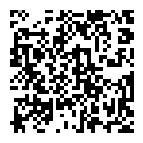

In [26]:
# Plot results
nb_images = 1
samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
plt.figure(figsize=(17, 17))
for i in range(nb_images):
    plt.subplot(9, 9, 1 + i)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(),
               cmap='gray')
plt.savefig(f'samples.png')